In [ ]:
# pip install seaborn
# pip install numpy==1.23.5
# pip install gym
# pip install scikit-learn
# python version: 3.9.6

In [46]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.stats import mode
import seaborn as sns
from collections import defaultdict
import copy 
import matplotlib.animation as animation
import math

In [47]:
def supervised_learning():
    digits = load_digits()
    X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

    # Print sample data
    print("🔹 First 5 Samples Passed to the Supervised Model:")
    for i in range(5):
        print(f"Label: {y_train[i]}")
        print(f"Flattened Features: {X_train[i]}\n")

    plt.imshow(X_train[0].reshape(8, 8), cmap="gray")
    plt.title(f"Example Image (Label: {y_train[0]})")
    plt.show()

    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    accuracy = model.score(X_test, y_test)
    print(f"Supervised Learning - Decision Tree Accuracy: {accuracy:.2f}")

    # Show examples of correctly classified digits
    preds = model.predict(X_test)
    correct_indices = np.where(preds == y_test)[0][:10]  # Select 10 correctly classified digits
    incorrect_indices = np.where(preds != y_test)[0][:10]

    feature_importance = model.feature_importances_.reshape(8, 8)

    # Plot heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(feature_importance, cmap="hot", interpolation="nearest")
    plt.colorbar(label="Feature Importance")
    plt.title("Pixel Importance in Decision Tree Classification")
    plt.xlabel("Pixel X Position")
    plt.ylabel("Pixel Y Position")
    plt.show()

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X_test[correct_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {preds[correct_indices[i]]}, True: {y_test[correct_indices[i]]}")
        ax.axis('off')
    plt.show()

    fig2, axes2 = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes2.flat):
        ax.imshow(X_test[incorrect_indices[i]].reshape(8, 8), cmap='gray')
        ax.set_title(f"Pred: {preds[incorrect_indices[i]]}, True: {y_test[incorrect_indices[i]]}")
        ax.axis('off')
    plt.show()


In [48]:
def unsupervised_learning():
    digits = load_digits()
    X, y_true = digits.data, digits.target

    model = KMeans(n_clusters=10, random_state=42, n_init=10)
    cluster_labels = model.fit_predict(X)

    # Print sample data
    print("🔹 First 5 Samples Passed to the Unsupervised Model:")
    for i in range(5):
        print(f"True Label: {digits.target[i]} → Cluster Assigned: {cluster_labels[i]}")
        print(f"Flattened Features: {digits.data[i]}\n")

    # Reshape and display one sample as an image
    plt.imshow(digits.data[0].reshape(8, 8), cmap="gray")
    plt.title(f"Example Image (True Label: {digits.target[0]}, Cluster: {cluster_labels[0]})")
    plt.show()

    # Get cluster centroids (reshape to 8x8 images)
    centroids = model.cluster_centers_.reshape(10, 8, 8)

    # Plot cluster centroids as images
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(centroids[i], cmap="gray")
        ax.set_title(f"Cluster {i}")
        ax.axis("off")

    plt.suptitle("Cluster Centroids (Prototypes of Digits Found by K-Means)")
    plt.show()

    # Map each cluster to the most common true label
    cluster_map = {}
    for cluster in range(10):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:  # Ensure there are samples in this cluster
            most_common_label = mode(y_true[cluster_indices], keepdims=True).mode[0]
            cluster_map[cluster] = most_common_label

    print(f"Cluster Mapping (K-Means Cluster → True Digit): {cluster_map}")

    # Show examples from each cluster with mapped labels
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for cluster in range(10):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:  # Ensure the cluster is not empty
            sample_idx = cluster_indices[0]  # Select first image in the cluster
            ax = axes[cluster // 5, cluster % 5]
            ax.imshow(X[sample_idx].reshape(8, 8), cmap='gray')
            ax.set_title(f"Cluster {cluster} → {cluster_map[cluster]}")
            ax.axis('off')
    plt.show()

Reinforcement Learning - Q-Learning Training Complete

FrozenLake Map:
None

Best Actions Learned by Q-Learning:
→  →  ↓  ←
↓  ←  ↓  ←
→  →  ↓  ←
←  →  →  ←


/Users/shevalik/Library/Python/3.9/lib/python/site-packages/gym/envs/toy_text/frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(


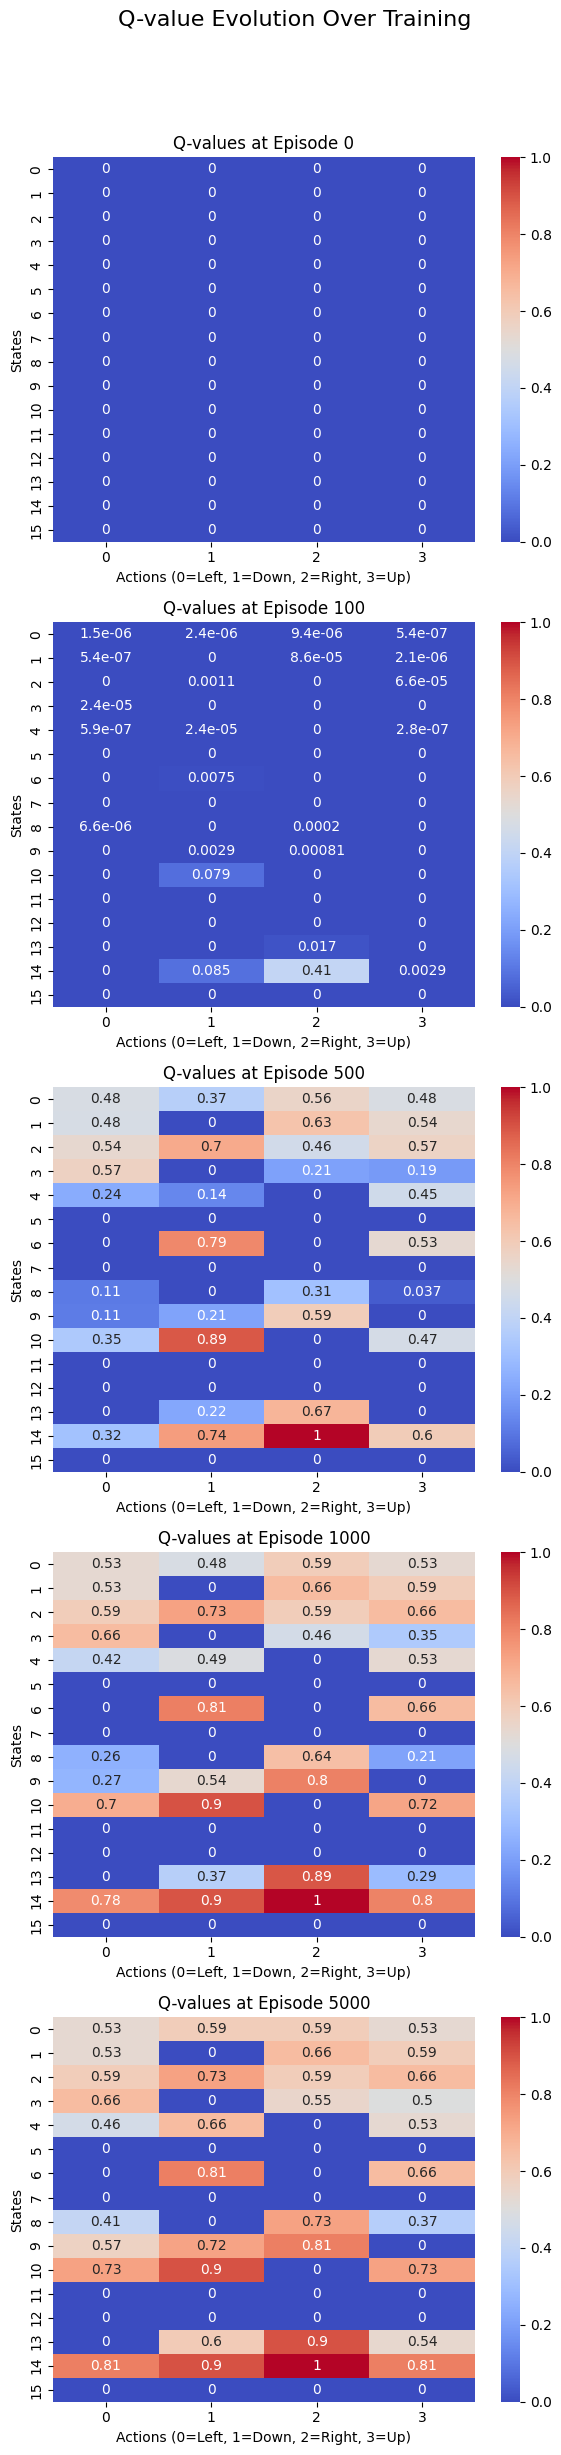

✅ Animation saved as q_table_animation.gif


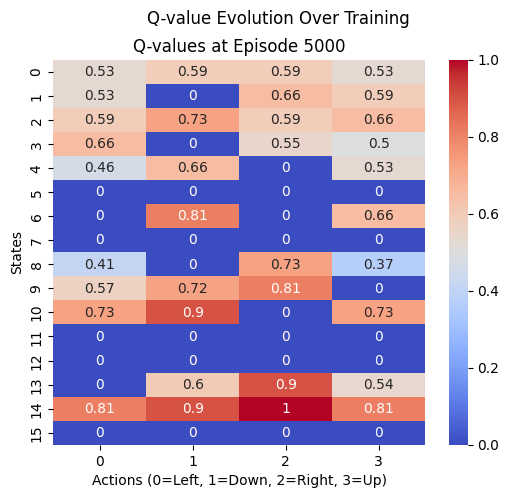

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from collections import defaultdict
import copy  # 🔹 Use deep copy to store snapshots properly!
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import math

# Define action meanings
ACTION_MAP = {0: '←', 1: '↓', 2: '→', 3: '↑'}

def reinforcement_learning():
    env = gym.make("FrozenLake-v1", is_slippery=False)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor
    epsilon = 1.0  # Start with full exploration
    epsilon_decay = 0.999  # Gradually reduce exploration
    epsilon_min = 0.1  # Minimum exploration rate
    episodes = 5001  # Train for more episodes

    q_value_snapshots = []  # Store Q-table at different intervals
    snapshot_intervals = [0, 100, 500, 1000, 5000]  # Capture Q-values at these episodes

    for episode in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            state = next_state

        epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Reduce exploration over time

        # 🔹 Store **actual copies** of Q-values at specific intervals
        if episode in snapshot_intervals:
            q_value_snapshots.append(copy.deepcopy(dict(Q)))  

    print("Reinforcement Learning - Q-Learning Training Complete")

    # --- 📌 Step 1: Print the FrozenLake Map ---
    print("\nFrozenLake Map:")
    print(env.render())

    # --- 📊 Visualization 1: Best Action Per State ---
    policy_grid = np.full((4, 4), ' ', dtype=str)
    for state in range(env.observation_space.n):
        best_action = np.argmax(Q[state])
        policy_grid[state // 4, state % 4] = ACTION_MAP[best_action]

    print("\nBest Actions Learned by Q-Learning:")
    for row in policy_grid:
        print("  ".join(row))

    # --- 📊 Visualization 2: Q-Value Heatmap Over Time ---
    # Define grid size (2 rows)
    num_snapshots = len(q_value_snapshots)
    cols = 1  # Number of columns
    rows = 5  # Fixed to 2 rows
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])
    vmin, vmax = np.min(all_q_values), np.max(all_q_values)

    # Create subplots with 2 rows
    fig, axes = plt.subplots(rows, cols, figsize=(6, 25))  # Adjust height to fit better
    axes = axes.flatten()  # Flatten axes for easier indexing

    for i, q_snapshot in enumerate(q_value_snapshots):
        q_table_array = np.zeros((env.observation_space.n, env.action_space.n))
        
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=axes[i], vmin=vmin, vmax=vmax)
        axes[i].set_title(f"Q-values at Episode {snapshot_intervals[i]}")
        axes[i].set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        axes[i].set_ylabel("States")

    # Hide any unused subplots (if len(q_value_snapshots) is odd)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Q-value Evolution Over Training", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


    fig, ax = plt.subplots(figsize=(6, 5))

    # Find global min and max values for consistent color scaling
    all_q_values = np.concatenate([
        np.array([list(snapshot.get(state, np.zeros(env.action_space.n))) for state in range(env.observation_space.n)])
        for snapshot in q_value_snapshots
    ])

    vmin, vmax = np.min(all_q_values), np.max(all_q_values)  # Fixed color range

    # Initialize first Q-table
    q_table_array = np.zeros((env.observation_space.n, env.action_space.n))

    # Create the initial heatmap with fixed vmin, vmax
    heatmap = sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=True, ax=ax, vmin=vmin, vmax=vmax)
    cbar = heatmap.collections[0].colorbar  # Store the colorbar reference

    def update(frame):
        """Update the heatmap for each frame without changing the color scale."""
        q_snapshot = q_value_snapshots[frame]

        # Update Q-table array with the new snapshot
        for state in range(env.observation_space.n):
            q_table_array[state] = q_snapshot.get(state, np.zeros(env.action_space.n))  # Ensure all states exist

        # Clear old heatmap but keep the color scale
        ax.clear()

        # Redraw heatmap with consistent color scale
        sns.heatmap(q_table_array, annot=True, cmap="coolwarm", cbar=False, ax=ax, vmin=vmin, vmax=vmax)

        ax.set_title(f"Q-values at Episode {snapshot_intervals[frame]}")
        ax.set_xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
        ax.set_ylabel("States")

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=len(q_value_snapshots), repeat=True)

    # Save as GIF
    gif_filename = "q_table_animation.gif"
    anim.save(gif_filename, writer=animation.PillowWriter(fps=1))
    print(f"✅ Animation saved as {gif_filename}")

    plt.suptitle("Q-value Evolution Over Training")
    plt.show()



🔹 First 5 Samples Passed to the Supervised Model:
Label: 6
Flattened Features: [ 0.  0.  3. 14.  1.  0.  0.  0.  0.  0. 12. 12.  0.  0.  0.  0.  0.  3.
 16.  6.  0.  0.  0.  0.  0.  5. 16.  2.  0.  0.  0.  0.  0.  6. 16.  2.
  5.  2.  0.  0.  0.  4. 16.  2. 12. 15.  2.  0.  0.  1. 14. 13.  2. 13.
 11.  0.  0.  0.  3. 11. 16. 13.  4.  0.]

Label: 0
Flattened Features: [ 0.  0.  9.  9.  4.  0.  0.  0.  0.  0. 15. 15. 14. 12.  0.  0.  0.  3.
 10.  1.  0. 12.  5.  0.  0.  5.  8.  0.  0.  8.  6.  0.  0.  8.  8.  0.
  0.  8.  8.  0.  0.  5.  8.  0.  0. 10.  6.  0.  0.  4. 13.  4.  6. 13.
  0.  0.  0.  0.  6. 16. 14.  3.  0.  0.]

Label: 0
Flattened Features: [ 0.  0.  0. 10. 13.  3.  0.  0.  0.  0.  8. 16. 14. 12.  0.  0.  0.  3.
 16. 13.  0. 14.  1.  0.  0.  5. 16.  6.  0. 14.  5.  0.  0.  6. 16.  0.
  0. 15.  4.  0.  0.  2. 13.  1.  5. 16.  4.  0.  0.  0. 10. 16. 16. 14.
  1.  0.  0.  0.  2. 11. 13.  6.  0.  0.]

Label: 3
Flattened Features: [ 0.  1. 10. 16. 16. 11.  0.  0.  0.  5. 10.  8.

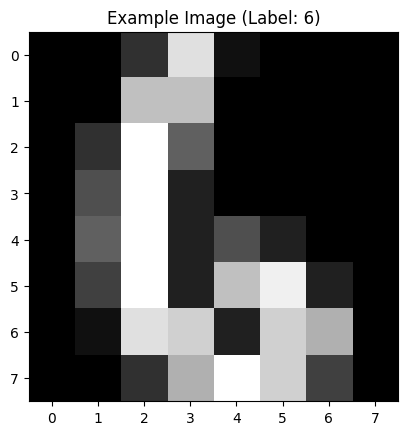

Supervised Learning - Decision Tree Accuracy: 0.87


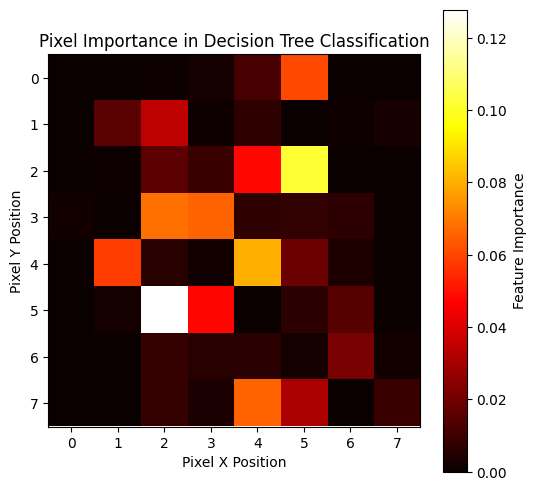

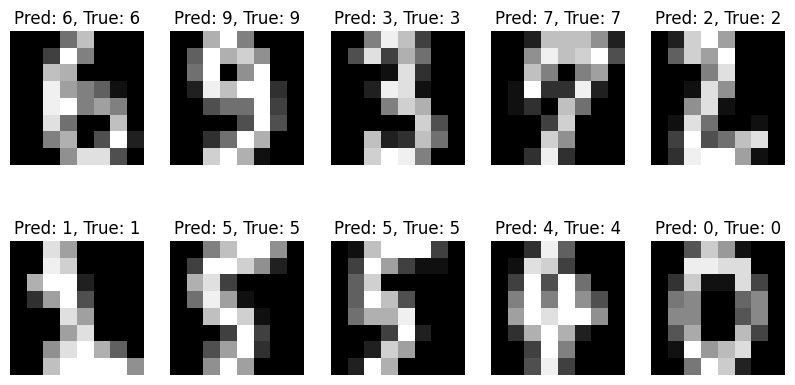

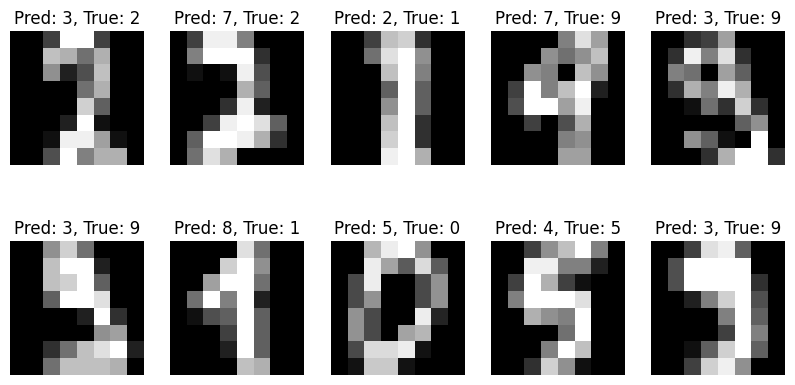

🔹 First 5 Samples Passed to the Unsupervised Model:
True Label: 0 → Cluster Assigned: 1
Flattened Features: [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]

True Label: 1 → Cluster Assigned: 3
Flattened Features: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]

True Label: 2 → Cluster Assigned: 3
Flattened Features: [ 0.  0.  0.  4. 15. 12.  0.  0.  0.  0.  3. 16. 15. 14.  0.  0.  0.  0.
  8. 13.  8. 16.  0.  0.  0.  0.  1.  6. 15. 11.  0.  0.  0.  1.  8. 13.
 15.  1.  0.  0.  0.  9. 16. 16.  5.  0.  0.  0.  0.  3. 13. 16. 16. 11.
  5.  0.  0.  0.  0.  3. 11. 16.  9. 

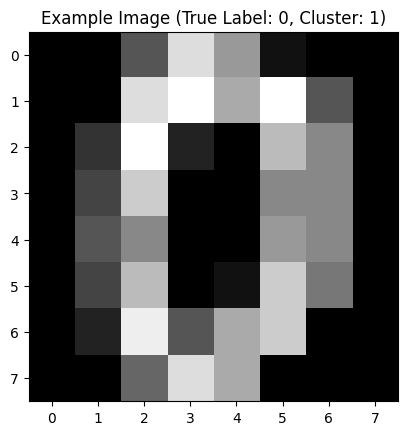

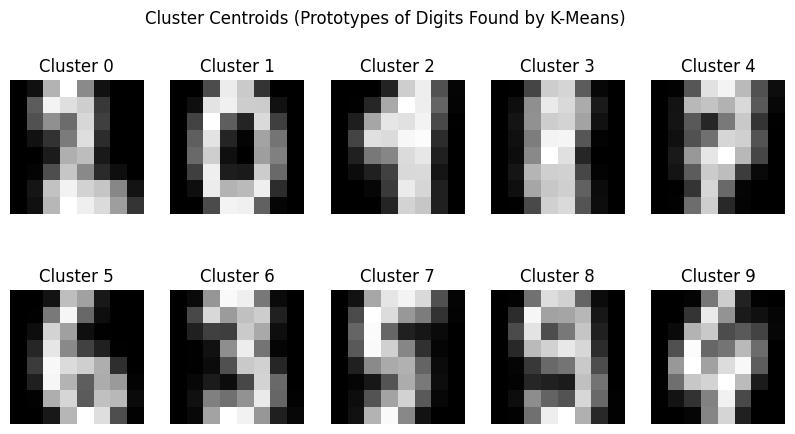

Cluster Mapping (K-Means Cluster → True Digit): {0: 2, 1: 0, 2: 1, 3: 8, 4: 7, 5: 6, 6: 3, 7: 5, 8: 9, 9: 4}


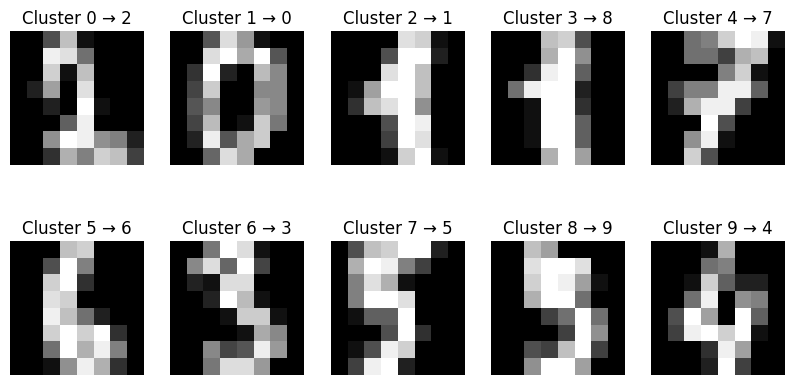

In [50]:
supervised_learning()
unsupervised_learning()




Reinforcement Learning - Q-Learning Training Complete

FrozenLake Map:
None

Best Actions Learned by Q-Learning:
↓  ←  ↓  ←
↓  ←  ↓  ←
→  →  ↓  ←
←  →  →  ←


/Users/shevalik/Library/Python/3.9/lib/python/site-packages/gym/envs/toy_text/frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(


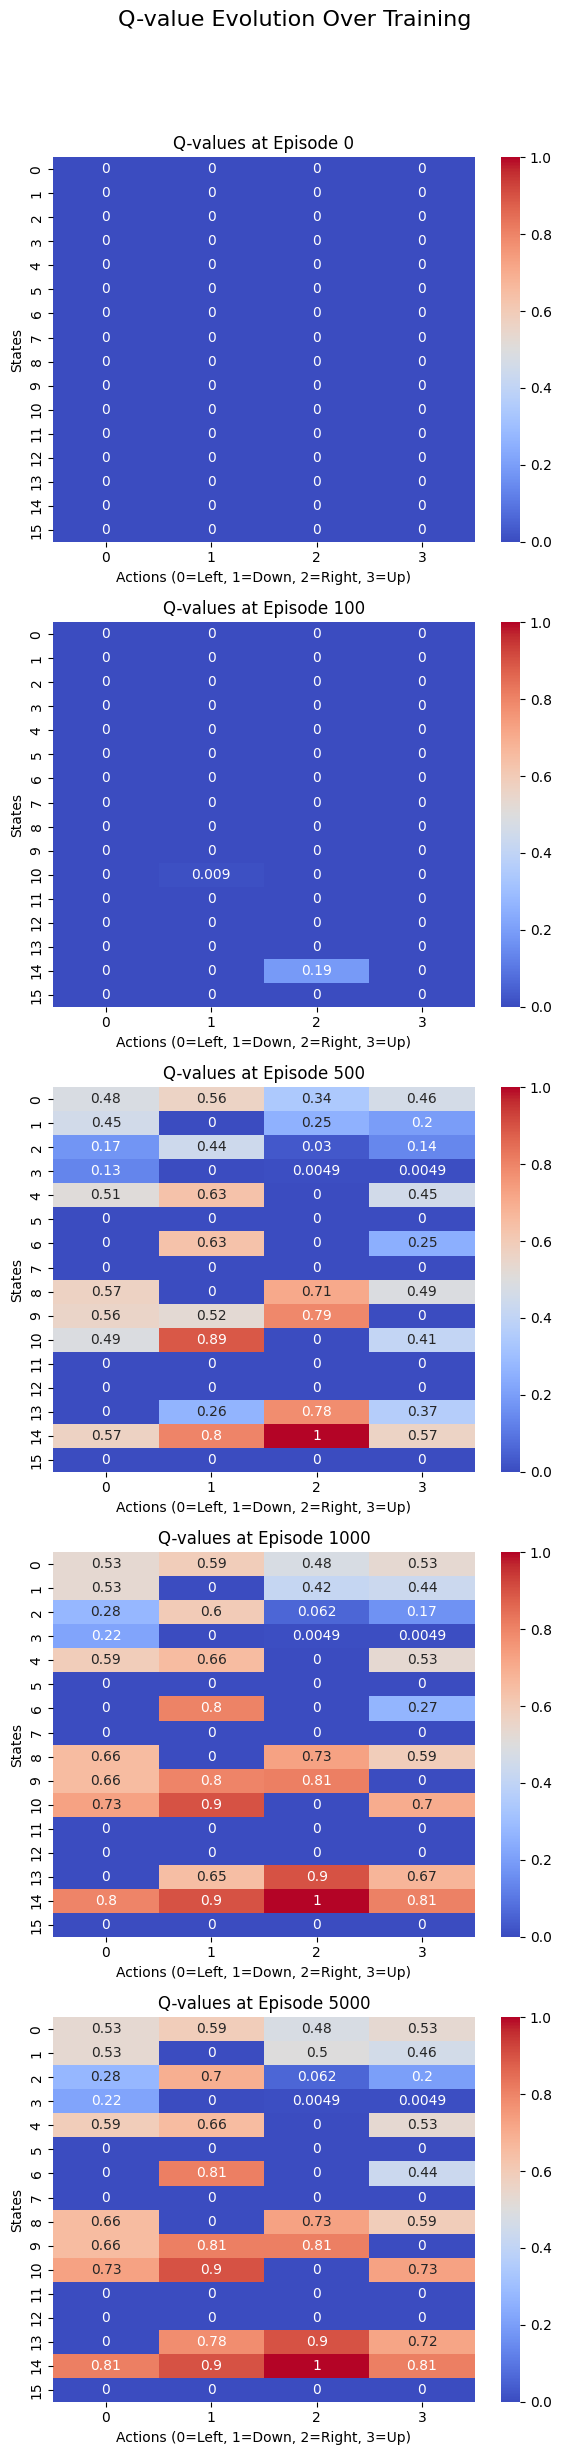

✅ Animation saved as q_table_animation.gif


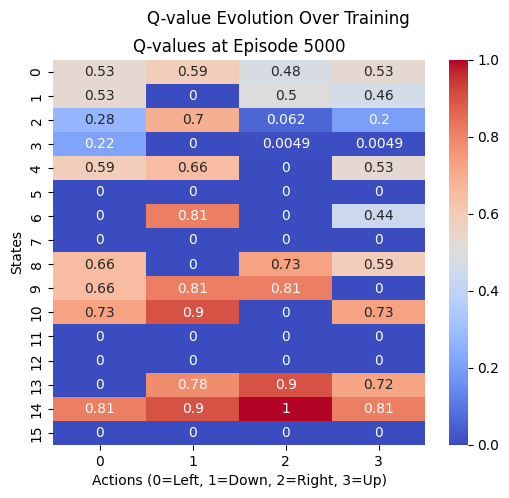

In [51]:
reinforcement_learning()